# Tryouts with pix2pix NNs

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import sys
sys.path.append("../common/")

import cv2
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS, ORDERED_LABEL_IDS, TRAIN_DATA, TRAIN_LABEL_TILES
from image_utils import get_image_data, get_image_tile_data, normalize
from visu_utils import display_img_1b, display_labels, plt_st

## Data generator

In [4]:
from glob import glob
all_train_files = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_files = np.array([s[len(TRAIN_DATA)+1:-4] for s in all_train_files if 'mean' not in s and 'std' not in s])
print "First train tile : ", all_train_files[0], all_train_files[-1], len(all_train_files)

First train tile :  6010_1_2 6170_4_1 25


In [ ]:
from image_utils import imwrite, compute_mean_std_on_images
from geo_utils.GeoImage import GeoImage

ll = int(len(all_train_files)*0.8)
train_files = all_train_files[:ll]
val_files = all_train_files[ll:]

feature_wise = True
s = ''
if feature_wise:
    s = "_feature_wise"

mean_fname = os.path.join(TRAIN_DATA, 'mean_image%s.tif' % s)
std_fname = os.path.join(TRAIN_DATA, 'std_image%s.tif' % s)
if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
    logging.getLogger().setLevel(logging.INFO)
    mean_image, std_image = compute_mean_std_on_images(train_files, 'input', feature_wise=feature_wise)
    logging.getLogger().setLevel(logging.ERROR)
    imwrite(mean_fname, mean_image)
    imwrite(std_fname, std_image)
else:
    mean_image = GeoImage(mean_fname).get_data()
    std_image = GeoImage(std_fname).get_data()

print mean_image.shape, std_image.shape
print mean_image.min(), mean_image.max(), std_image.min(), std_image.max()
print len(train_files), len(val_files)

logging.getLogger().setLevel(logging.ERROR)

In [ ]:
from data_utils import get_image_ids
from training_utils import tile_iterator

def normalize_image(img_data, mean_image=None, std_image=None):
    out = img_data.astype(np.float32)    
    if mean_image is not None or std_image is not None:
        out -= mean_image 
        out /= std_image
    out = out.transpose([2,0,1])
    return out

def generate_images(image_ids_to_use, batch_size):
    while True:        
        X = np.zeros((batch_size, n_channels)+tile_size[::-1], dtype=np.float32)
        Y = np.zeros((batch_size, n_labels)+tile_size[::-1], dtype=np.float32)
        tiles = tile_iterator(image_ids_to_use, labels,
                              image_type='input', label_type='label',
                              balance_classes=True,
                              presence_percentage=20, 
                              tile_size=tile_size, 
                              mean_image=mean_image,
                              std_image=std_image,
                              #random_rotation_angles=(15.0,),
                              resolution_levels=(1,),
                              n_images_same_time=5,
                              verbose_image_ids=False
                             )
        counter = 0
        for x, y in tiles:     

            if len(channels) < 17:
                x = x[:,:,channels]
            
            x = normalize_image(x)
            y = y.transpose([2,0,1])   

            X[counter,:,:,:] = x
            Y[counter,:,:,:] = y 
            counter += 1
            if counter == batch_size:
                yield (X, Y)
                counter = 0

Training class groups : number of pixels x appearence frequency ~ probability that a pixel of the image is of a class

1. `Buildings` and `Misc. Manmade structures` and `Track` : [1, 2, 4]
2. `Standing water` and `Road` and `Waterway` : [8, 3, 7]
3. `Trees` and `Crops`: [5, 6]
4. `Vehicle Small` : [10]
5. `Vehicle Large` : [9]


Input image bands:

```
Pan, NDVI, GEMI, NDWI2, NDTI, BI, BI2, -BI, -BI2, Coastal, Blue, Green, Yellow, Red, Red Edge, Near-IR1, Near-IR2
 0     1     2     3      4    5   6     7    8      9      10     11     12     13     14        15        16
```


In [ ]:
shape = get_image_data(TRAIN_IMAGE_IDS[0], 'input', return_shape_only=True)

tile_size = (256, 256)
# Select red, green, 
channels = np.array([0,10,11,12,13])
n_channels = len(channels)

# labels = ORDERED_LABEL_IDS[1:]
# labels = list(range(1,len(LABELS)))
labels = np.array([1,2,4])
n_labels = len(labels)

In [ ]:
channels, labels, np.array(LABELS)[labels]

(5, 5, 256, 256) (5, 3, 256, 256)
-5.91765 14.572 0.0 1.0


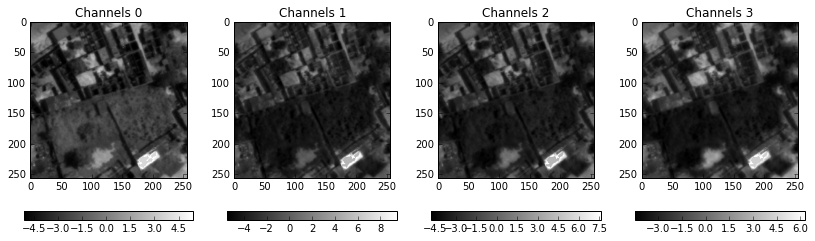

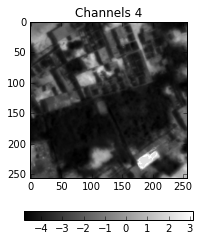

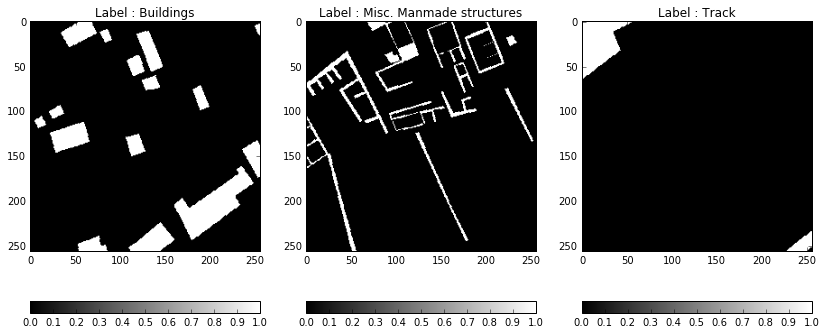

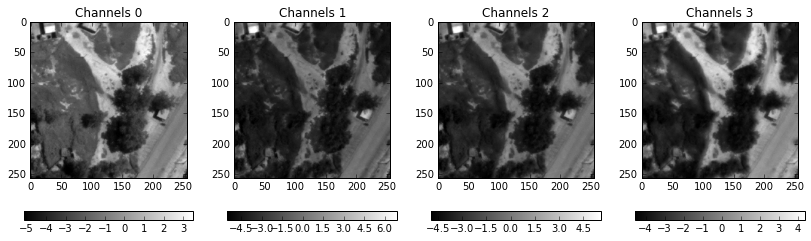

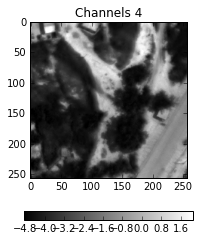

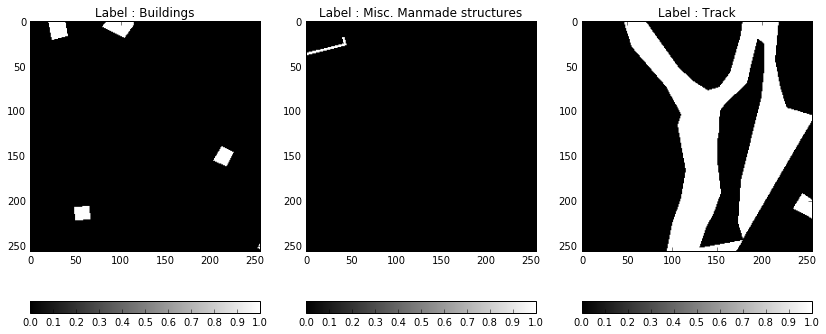

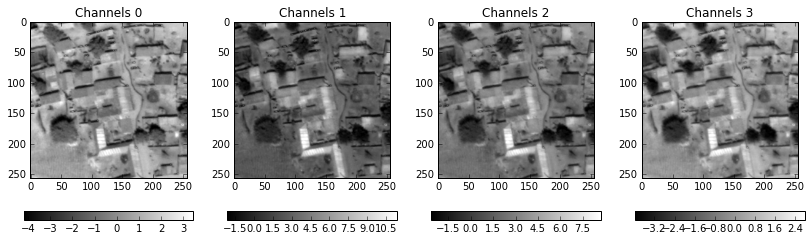

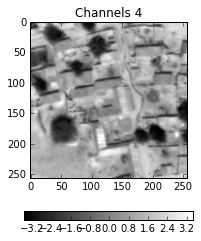

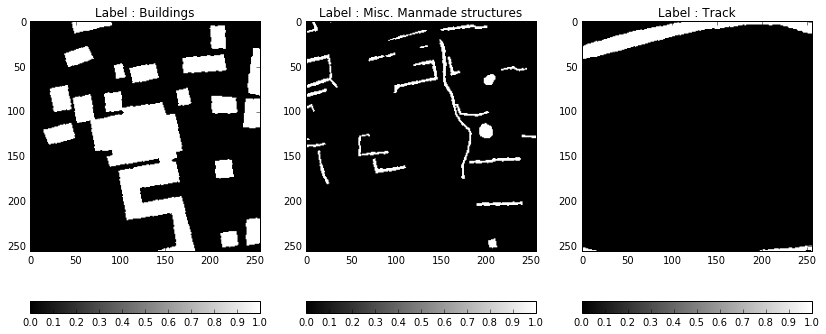

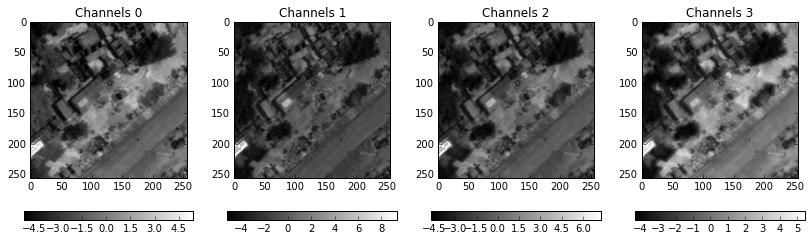

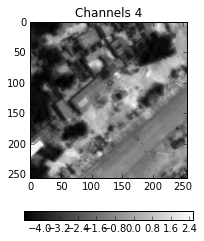

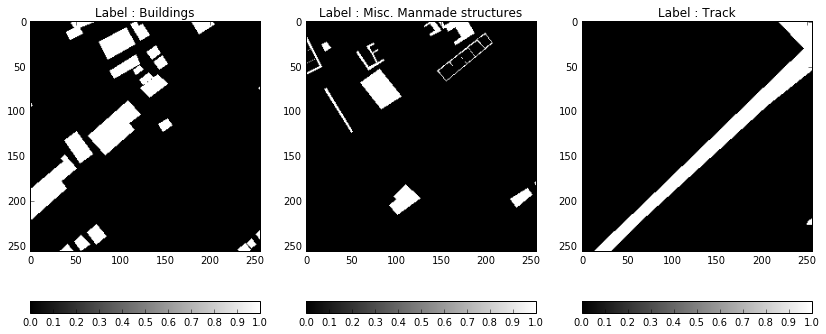

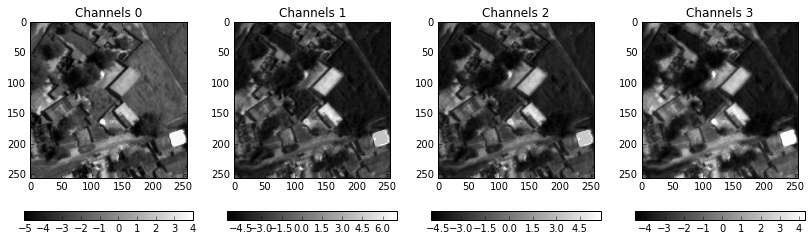

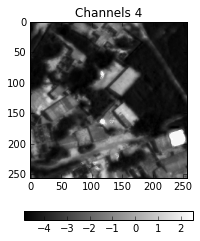

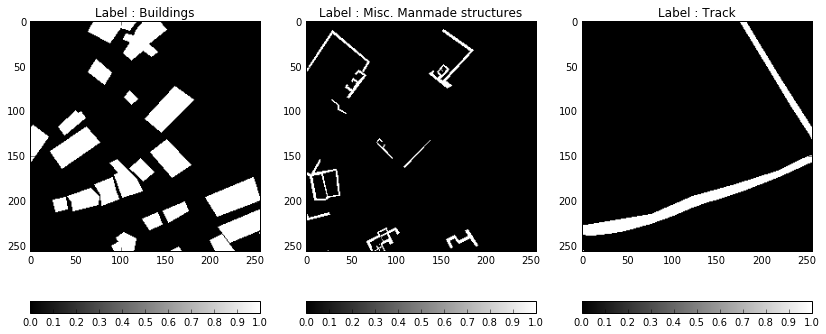

In [16]:
batch_size = 5
for X, Y in generate_images(train_files, batch_size):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    #print [X[c,:,:,:].min() for c in range(X.shape[0])]
    
    _channels = min(15, n_channels)
    for i in range(batch_size):
        
        m = 4
        for j in range(_channels):
            if j % m == 0:
                plt.figure(figsize=(14, 4))                
            plt.subplot(1,m,j % m +1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if n_labels < 8:
            n, m = 1, n_labels
        else:
            n, m = 3, int(n_labels * 1.0 / 3.0 + 1.0), 
        for j in range(n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

## Load generator and discriminator

In [17]:
from keras.optimizers import Adam
import keras.backend as K

import pix2pix_models as models

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5103)


In [18]:
patch_size = (256, 256) # can be 16, 16 and specifies patch size for PatchGAN
generator = "upsampling"
model_name = "generator_unet_%s" % generator

in_img_dim = (n_channels, tile_size[1], tile_size[0])
out_img_dim = (n_labels, tile_size[1], tile_size[0])

nb_patch = (in_img_dim[1] / patch_size[0]) * (in_img_dim[2] / patch_size[1])
img_dim_disc = (out_img_dim[0], patch_size[0], patch_size[1])

bn_mode = 2 # Feature-wise batch normalization
use_mbd = False

print nb_patch, img_dim_disc

1 (3, 256, 256)


In [19]:
# Load generator model
generator_model = models.load("generator_unet_%s" % generator,
                              in_img_dim, out_img_dim,
                              None,
                              bn_mode,
                              use_mbd)
# Load discriminator model
discriminator_model = models.load("DCGAN_discriminator",
                                  None, img_dim_disc,
                                  nb_patch,
                                  bn_mode,
                                  use_mbd)


-- Generator U-Net with upsampling
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
unet_input (InputLayer)          (None, 5, 256, 256)   0                                            
____________________________________________________________________________________________________
unet_conv2D_1 (Convolution2D)    (None, 64, 128, 128)  2944        unet_input[0][0]                 
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 64, 128, 128)  0           unet_conv2D_1[0][0]              
____________________________________________________________________________________________________
unet_conv2D_2 (Convolution2D)    (None, 128, 64, 64)   73856       leakyrelu_1[0][0]                
_______________________________________________________

In [20]:
from metrics import jaccard_coef_int, jaccard_coef

opt_dcgan = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt_discriminator = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

loss = ['binary_crossentropy']

generator_model.compile(loss=loss, optimizer=opt_discriminator)
discriminator_model.trainable = False

In [21]:
DCGAN_model = models.DCGAN(generator_model, discriminator_model, in_img_dim, out_img_dim, patch_size)

def l1_loss(y_true, y_pred):
    return K.sum(K.abs(y_pred - y_true), axis=-1)

loss = [l1_loss, 'binary_crossentropy']
loss_weights = [10, 1]
DCGAN_model.compile(loss=loss, loss_weights=loss_weights, optimizer=opt_dcgan)

discriminator_model.trainable = True
discriminator_model.compile(loss='binary_crossentropy', optimizer=opt_discriminator)

In [22]:
nb_epoch = 10 # 400
label_smoothing = True
label_flipping = 0.0
batch_size = 4
n_batch_per_epoch = 100
epoch_size = n_batch_per_epoch * batch_size

In [23]:
# # Load weights :
# e = 2
# gen_weights_path = os.path.join('models/gen_weights_epoch_%s.h5' % e)
# if os.path.exists(gen_weights_path):
#     generator_model.load_weights(gen_weights_path)

# disc_weights_path = os.path.join('models/disc_weights_epoch_%s.h5' % e)
# if os.path.exists(disc_weights_path):
#     discriminator_model.load_weights(disc_weights_path)

# DCGAN_weights_path = os.path.join('models/DCGAN_weights_epoch_%s.h5' % e)
# if os.path.exists(DCGAN_weights_path):
#     DCGAN_model.load_weights(DCGAN_weights_path)

In [27]:
import time
from pix2pix_training_utils import compute_disc_patches

try:
    # Start training
    print("Start training")
    for e in range(nb_epoch):
        # Initialize batch counter
        batch_counter = 1
        start = time.time()

        for X_in, X_out in generate_images(train_files, batch_size):
        #for X_full_batch, X_sketch_batch in data_utils.gen_batch(X_full_train, X_sketch_train, batch_size):
            print "--", batch_counter
            # Create a batch to feed the discriminator model
            X_disc_patches, y_disc = compute_disc_patches(X_in,
                                                X_out,
                                                generator_model,
                                                batch_counter,
                                                patch_size,
                                                label_smoothing=label_smoothing,
                                                label_flipping=label_flipping)
        
            # Update the discriminator                        
            disc_loss = discriminator_model.train_on_batch(X_disc_patches, y_disc)

            # Create a batch to feed the generator model
            X_gen_target, X_gen = next(generate_images(train_files, batch_size))
            y_gen = np.zeros((X_gen.shape[0], 2), dtype=np.uint8)
            y_gen[:, 1] = 1

            # Freeze the discriminator
            discriminator_model.trainable = False
            gen_loss = DCGAN_model.train_on_batch(X_gen_target, [X_gen, y_gen])
            # Unfreeze the discriminator
            discriminator_model.trainable = True

            batch_counter += 1
            print "D loss", disc_loss, "| G tot", gen_loss[0], \
                    "| G L1", gen_loss[1], "| G loss", gen_loss[2]
                
#             # Save images for visualization
#             if batch_counter % (n_batch_per_epoch / 2) == 0:
#                 # Get new images from validation
#                 data_utils.plot_generated_batch(X_full_batch, X_sketch_batch, generator_model,
#                                                 batch_size, image_dim_ordering, "training")
#                 X_full_batch, X_sketch_batch = next(data_utils.gen_batch(X_full_val, X_sketch_val, batch_size))
#                 data_utils.plot_generated_batch(X_full_batch, X_sketch_batch, generator_model,
#                                                 batch_size, image_dim_ordering, "validation")

            if batch_counter >= n_batch_per_epoch:
                break

        print("")
        print('Epoch %s/%s, Time: %s' % (e + 1, nb_epoch, time.time() - start))

        if e % 5 == 0:
            gen_weights_path = os.path.join('models/gen_weights_epoch_%s.h5' % e)
            generator_model.save_weights(gen_weights_path, overwrite=True)

            disc_weights_path = os.path.join('models/disc_weights_epoch_%s.h5' % e)
            discriminator_model.save_weights(disc_weights_path, overwrite=True)

            DCGAN_weights_path = os.path.join('models/DCGAN_weights_epoch_%s.h5' % e)
            DCGAN_model.save_weights(DCGAN_weights_path, overwrite=True)

except KeyboardInterrupt:
    pass


Start training
-- 1


MemoryError: Error allocating 167772160 bytes of device memory (CNMEM_STATUS_OUT_OF_MEMORY).
Apply node that caused the error: GpuAllocEmpty(Elemwise{switch,no_inplace}.0, Shape_i{1}.0, Elemwise{switch,no_inplace}.0, Elemwise{Composite{Switch(EQ(i0, i1), i2, i0)}}.0)
Toposort index: 1168
Inputs types: [TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar)]
Inputs shapes: [(), (), (), ()]
Inputs strides: [(), (), (), ()]
Inputs values: [array(5), array(128), array(256), array(256)]
Outputs clients: [[GpuDnnConvGradI{algo='none', inplace=True}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode='half', subsample=(1, 1), conv_mode='conv', precision='float32'}.0, Constant{1.0}, Constant{0.0})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [25]:
gen_weights_path = os.path.join('models/gen_weights_epoch_%s.h5' % e)
generator_model.save_weights(gen_weights_path, overwrite=True)

disc_weights_path = os.path.join('models/disc_weights_epoch_%s.h5' % e)
discriminator_model.save_weights(disc_weights_path, overwrite=True)

DCGAN_weights_path = os.path.join('models/DCGAN_weights_epoch_%s.h5' % e)
DCGAN_model.save_weights(DCGAN_weights_path, overwrite=True)

In [58]:
# def plot_generated_batch(X_in, X_out, generator_model, batch_size, suffix):

#     # Generate images
#     X_gen = generator_model.predict(X_in)

#     X_out = inverse_normalization(X_out)
#     X_in = inverse_normalization(X_in)
#     X_gen = inverse_normalization(X_gen)
#     print X_gen.shape, X_gen.min(), X_gen.max()

#     Xs = X_out[:8]
#     Xg = X_gen[:8]
#     Xr = X_in[:8,1:4,:,:]
    
#     print Xs.shape, Xg.shape, Xr.shape
    
#     X = np.concatenate((Xs, Xg, Xr), axis=0)
#     list_rows = []
#     for i in range(int(X.shape[0] / 4)):
#         Xr = np.concatenate([X[k] for k in range(4 * i, 4 * (i + 1))], axis=2)
#         list_rows.append(Xr)

#     Xr = np.concatenate(list_rows, axis=1)
#     Xr = Xr.transpose(1,2,0)

#     if Xr.shape[-1] == 1:
#         plt.imshow(Xr[:, :, 0], cmap="gray")
#     else:
#         plt.imshow(Xr)
#     plt.axis("off")
#     #plt.savefig("figures/current_batch_%s.png" % suffix)
#     #plt.clf()


(4, 3, 256, 256) 0.23304 0.891131
(4, 3, 256, 256) (4, 3, 256, 256) (4, 3, 256, 256)


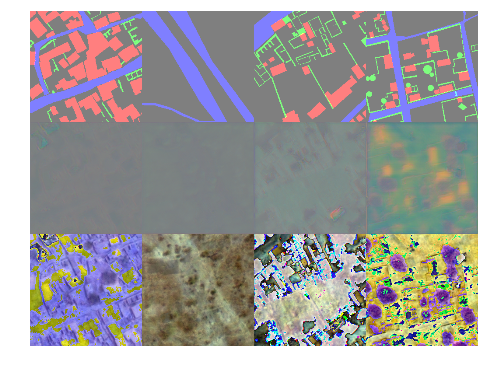

In [59]:
# for X_in, X_out in generate_images(train_files, batch_size):
#     plt.figure(figsize=(12,6))
#     plot_generated_batch(X_in, X_out, generator_model, batch_size, "training")
#     break

(5, 3, 256, 256) 1.30904e-13 1.0


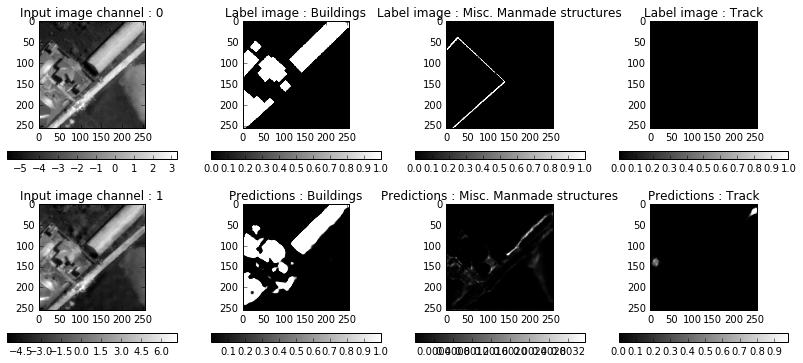

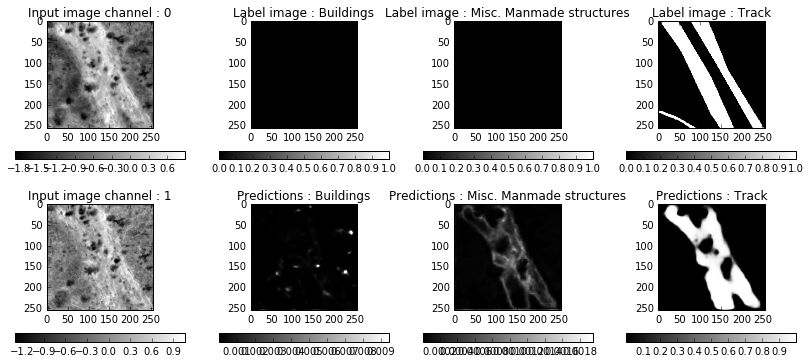

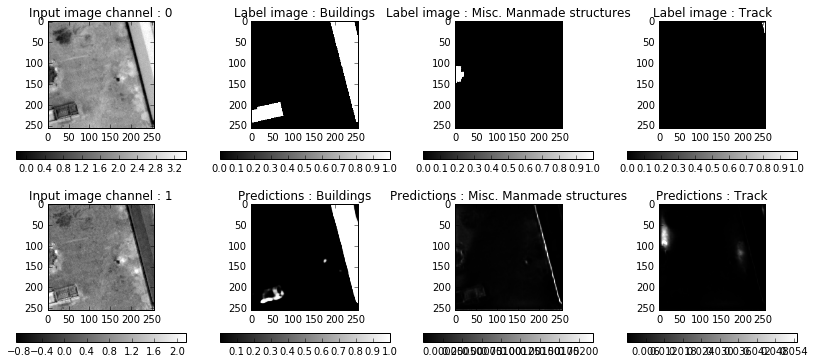

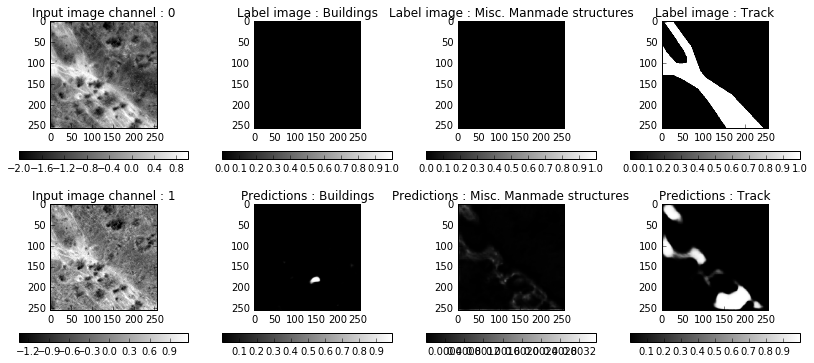

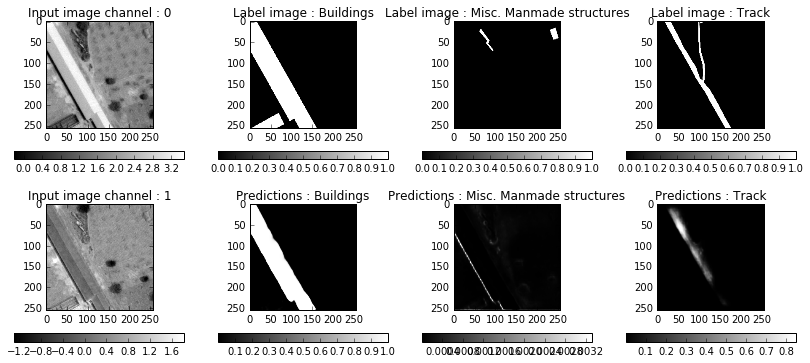

In [26]:
batch_size = 5

for X, Y in generate_images(train_files, batch_size):
    Y_pred = generator_model.predict(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

#     for i in range(batch_size):
#         _plot(X, Y, Y_pred, i)
#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:], clim=[0, 1])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break

View inside NN

In [20]:
from nn_visu_utils import display_layer_output, compute_layer_outputs
layer_output_f_dict = {}

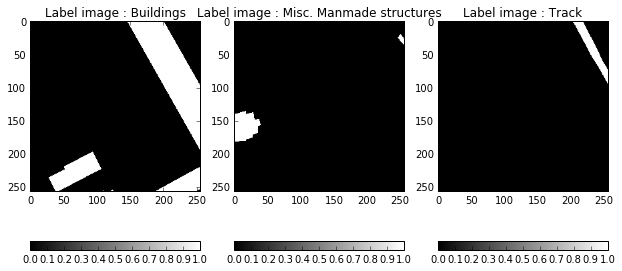

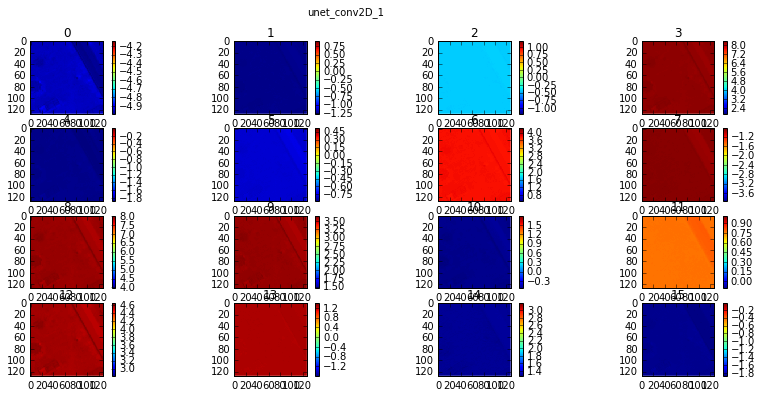

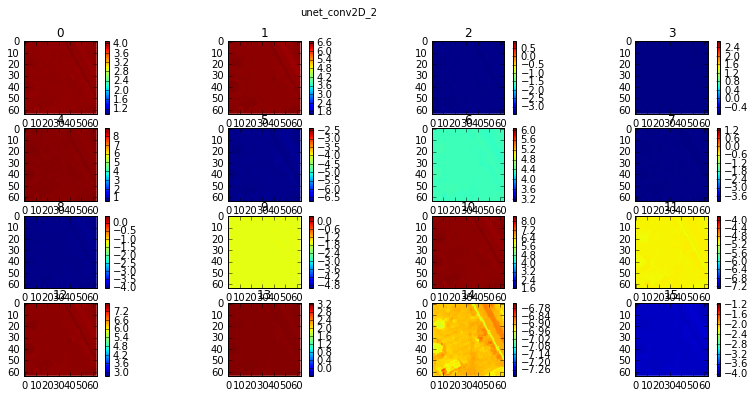

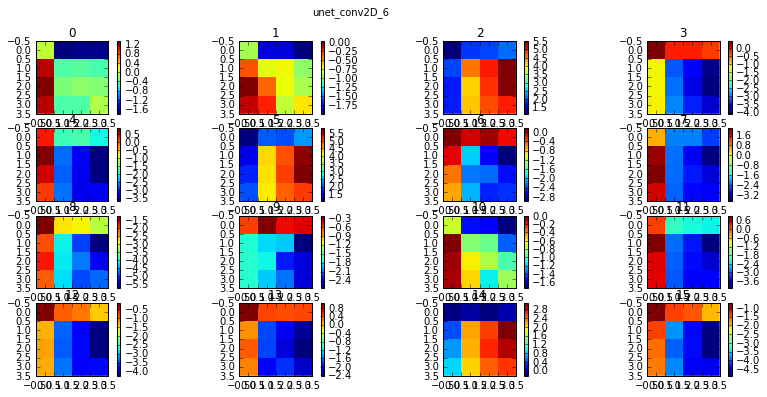

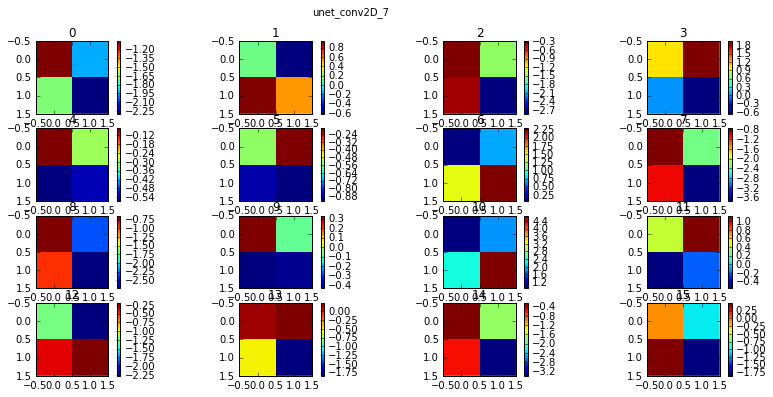

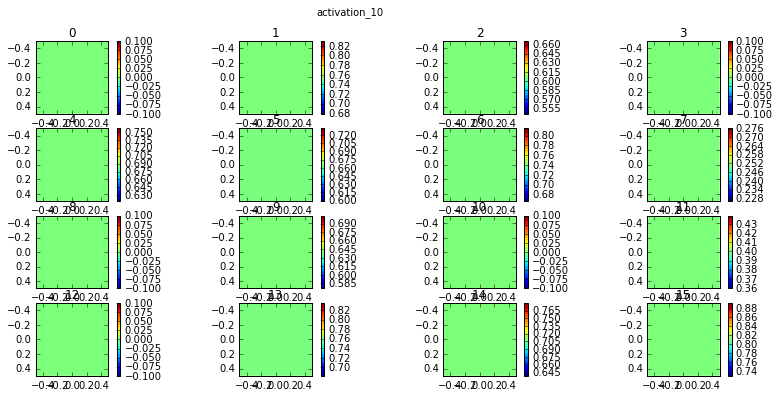

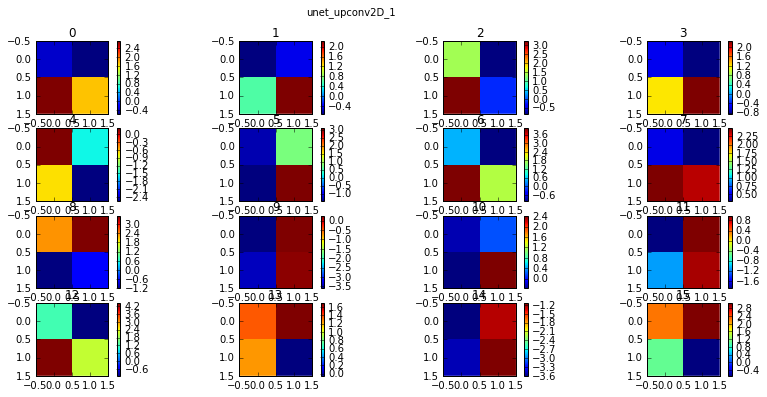

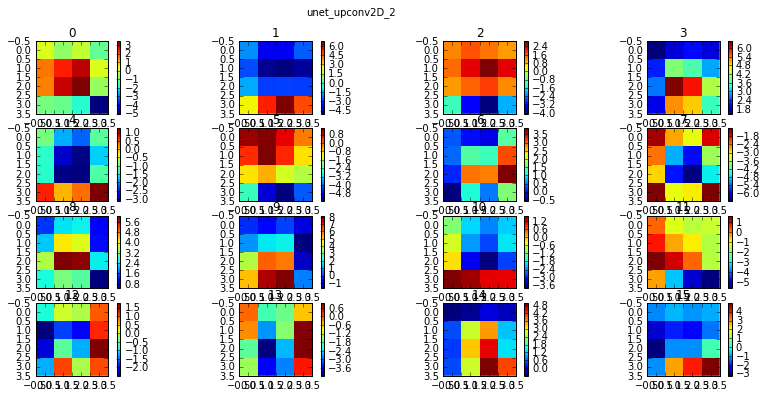

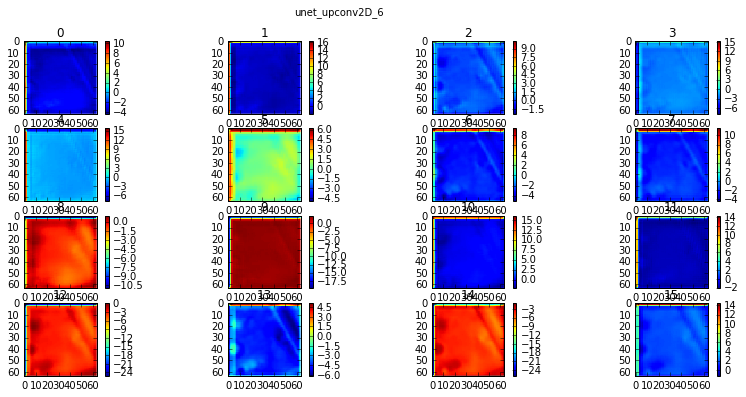

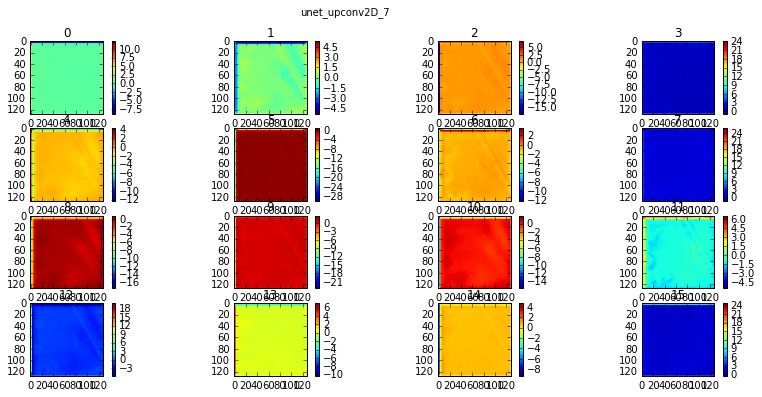

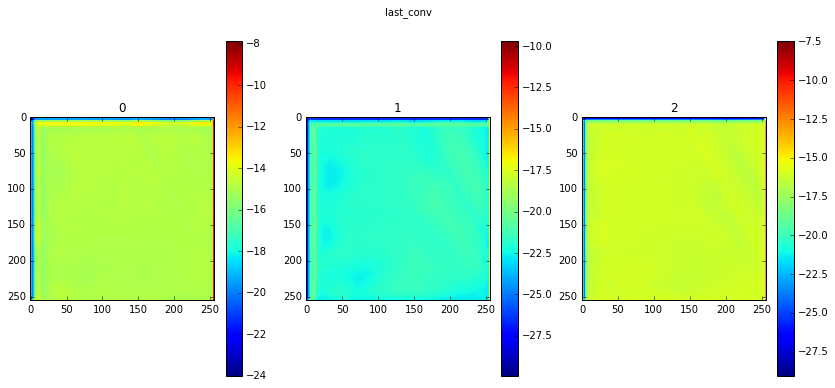

In [38]:
batch_size = 5

layer_names = [
    'unet_conv2D_1', 
    'unet_conv2D_2', 
    'unet_conv2D_6', 
    'unet_conv2D_7', 
    'activation_10',
    'unet_upconv2D_1', 
    'unet_upconv2D_2',     
    'unet_upconv2D_6',     
    'unet_upconv2D_7',     
    'last_conv'
]

for X, Y in generate_images(train_files, batch_size):
    
    layer_output_pairs = compute_layer_outputs(X, generator_model, layer_output_f_dict, layer_names)
    for i in range(batch_size):
        
        plt.figure(figsize=(14, 6))    
        plt.subplot(1,n_labels+1,1)
        for j in range(n_labels):
            plt.subplot(1,n_labels+1,j+1)
            display_img_1b(Y[i,j,:,:], clim=[0, 1])
            plt.title("Label image : %s" % LABELS[labels[j]])

        for (layer_name, layer_outputs) in layer_output_pairs:
            plt.figure(figsize=(14, 6))
            display_layer_output(layer_name, layer_outputs[0][i,:,:,:], 16)
        break
    break